# Number of serious reports per year

In [157]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt

# Connect to MongoDB (Adjust the connection string as necessary)
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  # Change 'your_database_name' to your database name
collection = db['reports']  # Change 'your_collection_name' to your collection name


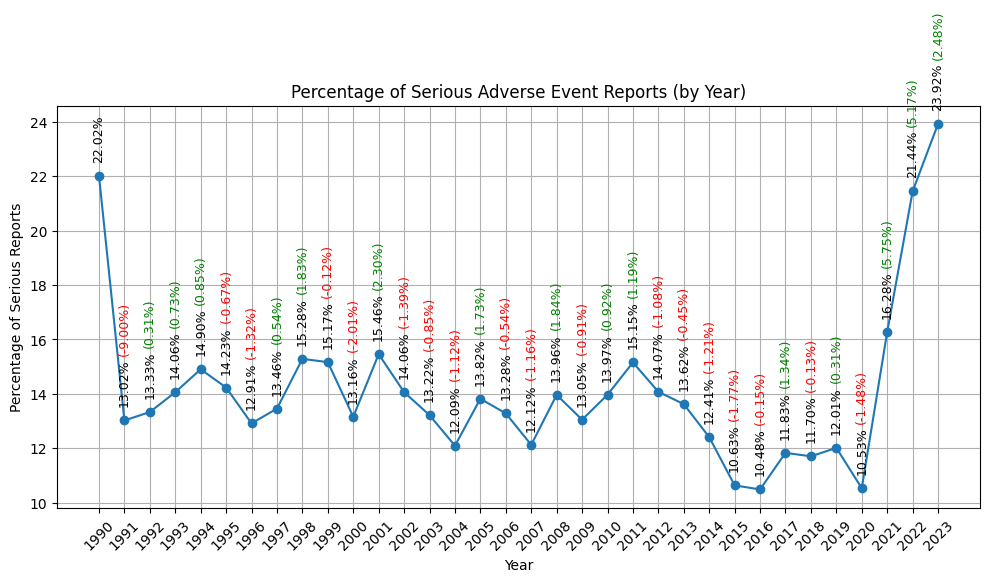

In [158]:
# Define the aggregation pipeline
pipeline = [
    {
        "$project": {
            "Year": {"$year": "$RECVDATE"},
            "SERIOUS": 1
        }
    },
    {
        "$group": {
            "_id": "$Year",
            "Total": {"$sum": 1},
            "SeriousCount": {"$sum": {"$cond": [{"$eq": ["$SERIOUS", 'Y']}, 1, 0]}}
        }
    },
    {
        "$project": {
            "Year": "$_id",
            "Total": 1,
            "SeriousCount": 1,
            "NotSeriousCount": {"$subtract": ["$Total", "$SeriousCount"]}
        }
    },
    {"$sort": {"Year": 1}}
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Convert the aggregation result into a DataFrame
aggregated_counts = pd.DataFrame(list(result))

# Calculate percentages
aggregated_counts['Percentage'] = (aggregated_counts['SeriousCount'] / aggregated_counts['Total']) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot line with dots
plt.plot(aggregated_counts['Year'], aggregated_counts['Percentage'], marker='o', linestyle='-')

plt.title('Percentage of Serious Adverse Event Reports (by Year)')
plt.xlabel('Year')
plt.ylabel('Percentage of Serious Reports')
plt.grid(True)
plt.xticks(aggregated_counts['Year'], rotation=45)

# Annotating with percentages and percentage change
for index, row in aggregated_counts.iterrows():
    plt.text(row['Year'], row['Percentage'] + 0.5, f'{row["Percentage"]:.2f}%', ha='center', va='bottom', rotation=90, fontsize=9)
    if index > 0:  # Skip the first year as there's no previous year to compare with
        percentage_change = row['Percentage'] - aggregated_counts.at[index - 1, 'Percentage']
        color = 'green' if percentage_change >= 0 else 'red'
        plt.text(row['Year'], row['Percentage'] + 2.5, f'({percentage_change:.2f}%)', ha='center', rotation=90, fontsize=9, color=color)


plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_per_Year.png')
plt.show()

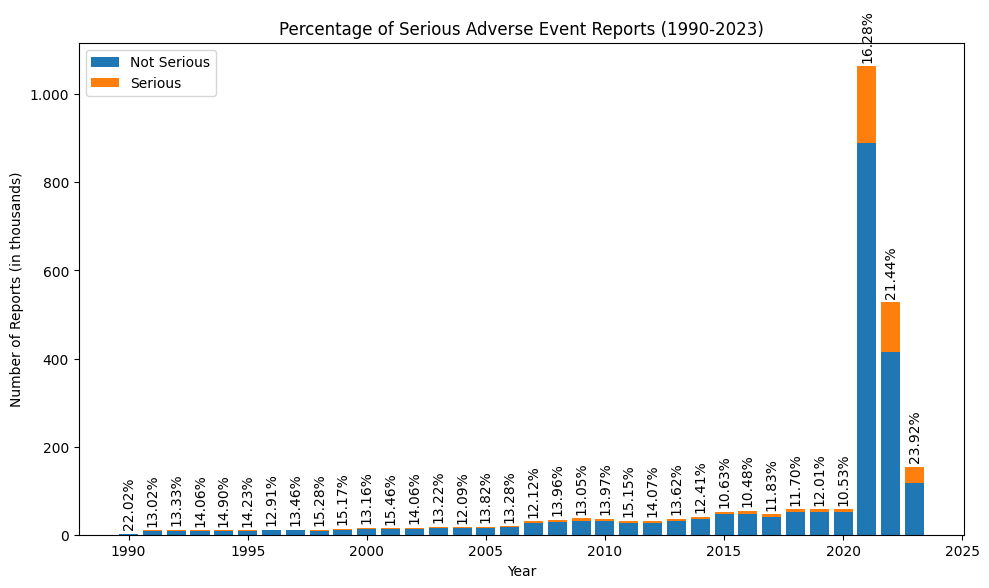

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a dictionary to store the aggregated counts
aggregated_counts = {}

# Construct the pipeline for MongoDB aggregation
pipeline = [
    {
        "$project": {
            "_id": 0,
            "Year": {"$year": "$RECVDATE"},
            "Serious": {"$cond": {"if": {"$eq": ["$SERIOUS", "Y"]}, "then": 1, "else": 0}}
        }
    },
    {
        "$group": {
            "_id": "$Year",
            "Serious": {"$sum": "$Serious"},
            "Total": {"$sum": 1}
        }
    }
]

# Execute the aggregation pipeline
results = list(collection.aggregate(pipeline))

# Store the aggregated counts
for entry in results:
    year = entry["_id"]
    serious_count = entry["Serious"]
    total_count = entry["Total"]
    aggregated_counts[year] = {"Serious": serious_count, "Not Serious": total_count - serious_count}

# Plotting
years = list(aggregated_counts.keys())
serious_counts = [aggregated_counts[year]["Serious"] for year in years]
not_serious_counts = [aggregated_counts[year]["Not Serious"] for year in years]

plt.figure(figsize=(10, 6))
bars1 = plt.bar(years, not_serious_counts, label='Not Serious')
bars2 = plt.bar(years, serious_counts, bottom=not_serious_counts, label='Serious')

plt.title('Percentage of Serious Adverse Event Reports (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Reports (in thousands)')
plt.legend()

# Annotating with percentages
for bar, year, serious_count, not_serious_count in zip(bars1, years, serious_counts, not_serious_counts):
    total = serious_count + not_serious_count
    percentage = (serious_count / total) * 100
    plt.annotate(f'{percentage:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, not_serious_count+serious_count), 
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', rotation=90)

# Adjusting y-axis to show values in thousands with dot as separator
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000).replace(',', '.')))

plt.tight_layout()
#plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_per_Year.png')
plt.show()


In [160]:
aggregated_counts

{1992: {'Serious': 1442, 'Not Serious': 9375},
 1999: {'Serious': 1953, 'Not Serious': 10925},
 2008: {'Serious': 4669, 'Not Serious': 28774},
 1991: {'Serious': 1301, 'Not Serious': 8691},
 2017: {'Serious': 5480, 'Not Serious': 40844},
 1998: {'Serious': 1648, 'Not Serious': 9134},
 2007: {'Serious': 3736, 'Not Serious': 27077},
 1990: {'Serious': 474, 'Not Serious': 1679},
 2016: {'Serious': 5630, 'Not Serious': 48067},
 2014: {'Serious': 5113, 'Not Serious': 36094},
 1997: {'Serious': 1562, 'Not Serious': 10046},
 2023: {'Serious': 36793, 'Not Serious': 117002},
 2006: {'Serious': 2567, 'Not Serious': 16763},
 2015: {'Serious': 5523, 'Not Serious': 46410},
 2013: {'Serious': 4937, 'Not Serious': 31309},
 1996: {'Serious': 1445, 'Not Serious': 9744},
 2022: {'Serious': 113072, 'Not Serious': 414202},
 2005: {'Serious': 2411, 'Not Serious': 15036},
 2012: {'Serious': 4519, 'Not Serious': 27588},
 2021: {'Serious': 173031, 'Not Serious': 890086},
 1995: {'Serious': 1462, 'Not Serious'

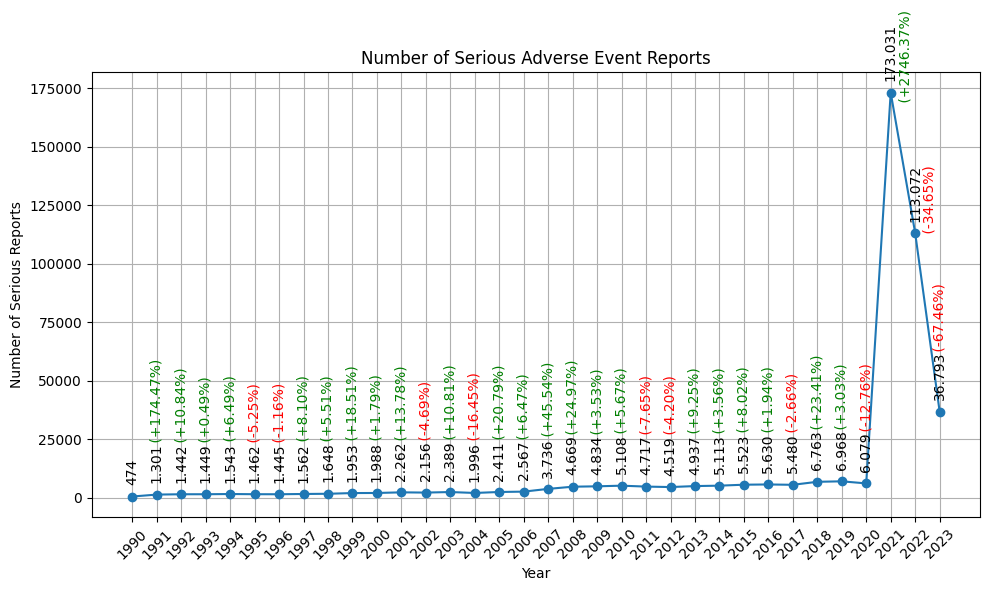

In [161]:
import matplotlib.pyplot as plt

# Define the pipeline for MongoDB aggregation
pipeline = [
    {
        "$project": {
            "_id": 0,
            "Year": {"$year": "$RECVDATE"},
            "Serious": {"$cond": {"if": {"$eq": ["$SERIOUS", "Y"]}, "then": 1, "else": 0}}
        }
    },
    {
        "$group": {
            "_id": "$Year",
            "Serious": {"$sum": "$Serious"}
        }
    }
]

# Execute the pipeline to fetch data from MongoDB
results = list(collection.aggregate(pipeline))

# Sort the results by year
results.sort(key=lambda x: x['_id'])

# Extract years and serious counts
years = [entry['_id'] for entry in results]
serious_counts = [entry['Serious'] for entry in results]

# Calculate percentage change from previous year
percentage_change = [0]  # Placeholder for the first year
for i in range(1, len(years)):
    change = ((serious_counts[i] - serious_counts[i-1]) / serious_counts[i-1]) * 100
    percentage_change.append(change)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, serious_counts, linestyle='-')  # Connect the dots with a line
plt.scatter(years, serious_counts, marker='o', zorder=5)  # Scatter plot with dots in foreground
plt.title('Number of Serious Adverse Event Reports')
plt.xlabel('Year')
plt.ylabel('Number of Serious Reports')

# Set x-ticks to the years in the dataset
plt.xticks(years, rotation=45)


for year, count, change in zip(years[:1], serious_counts[:1], percentage_change[:1]):
    count_text = f'{count:,}'.replace(',', '.')
    plt.annotate(count_text, (year, count + 5000), ha='center', va='bottom', fontsize=10, rotation=90)
    
# Annotate with numbers (Serious count) and percentage change
for year, count, change in zip(years[1:], serious_counts[1:], percentage_change[1:]):
    count_text = f'{count:,}'.replace(',', '.')
    percentage_text = f' ({change:+.2f}%)'
    color = 'green' if change > 0 else 'red'
    plt.annotate(count_text, (year, count + 5000), ha='center', va='bottom', fontsize=10, rotation=90)
    
    if count < 1000:
        offset = 15000
        xoffset = 0
    elif count < 10000:
        offset = 20500
        xoffset = 0
    elif count < 40000:
        offset = 24000
        xoffset = 0
    elif count < 150000:
        offset = -1900
        xoffset = 0.6
    else:
        offset = -6000
        xoffset = 0.6
    plt.annotate(percentage_text, (year + xoffset, count + offset), ha='center', va='bottom', fontsize=10, rotation=90, color=color)

plt.tight_layout()
plt.grid(True)
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_per_Year_Line.png')
plt.show()


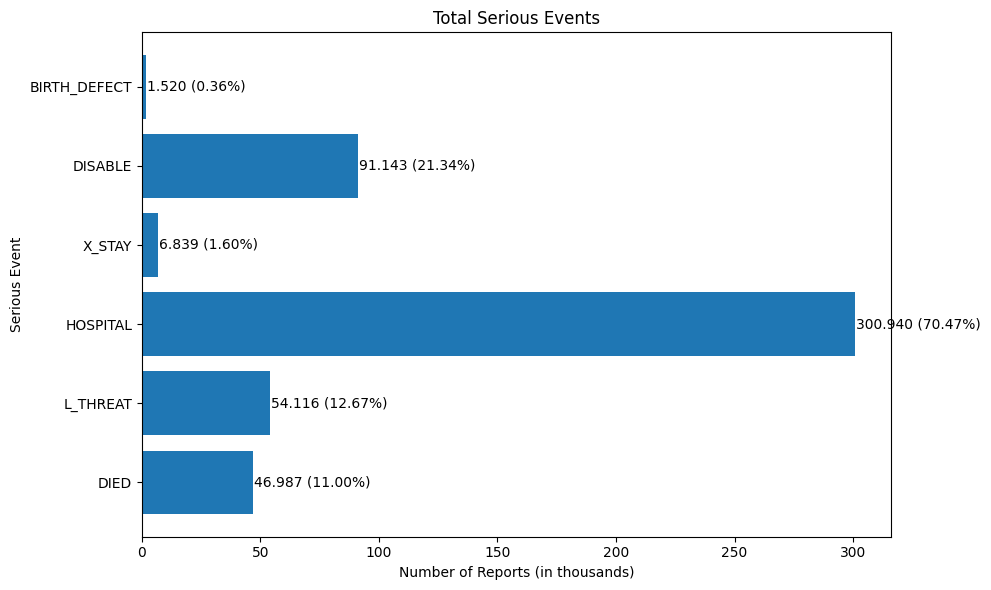

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

# Define the serious columns
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize a dictionary to store the counts for each serious event
serious_counts = {column: 0 for column in serious_columns}

# Construct the pipeline for MongoDB aggregation to fetch all serious reports
pipeline_serious_all = [
    {
        "$match": {
            "SERIOUS": "Y"  # Select only serious reports
        }
    }
]

# Execute the aggregation pipeline to fetch all serious reports
results_serious_all = list(collection.aggregate(pipeline_serious_all))

# Iterate over all serious reports
total_serious_reports = len(results_serious_all)
for entry in results_serious_all:
    # Count occurrences of each serious event
    for column in serious_columns:
        if entry.get(column, "") == "Y":
            serious_counts[column] += 1

# Create a DataFrame for plotting
serious_df = pd.DataFrame({'Count': serious_counts.values()}, index=serious_counts.keys())

# Plotting
plt.figure(figsize=(10, 6))

# Generating positions for the bars
y = np.arange(len(serious_df))

# Bar width
bar_width = 0.4

# Plot the bars
plt.barh(y, serious_df['Count'])

# Set y-axis labels
plt.yticks(y, serious_df.index)

# Add labels and title
plt.xlabel('Number of Reports (in thousands)')
plt.ylabel('Serious Event')
plt.title('Total Serious Events')

def format_with_period(number):
    return f'{number/1000:,.3f}'.replace(',', '.')  # Format with dot separator for thousands

# Add numbers to the bars with formatted values and percentages
for i, count in enumerate(serious_df["Count"]):
    percentage = (count / total_serious_reports) * 100
    plt.text(count + 500, i, f'{format_with_period(count)} ({percentage:.2f}%)', ha='left', va='center')


# Define the custom formatter function
def format_with_thousands_sep(x, pos):
    return f'{x/1000:,.0f}'

# Set the formatter for the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_with_thousands_sep))

# Show the plot
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_all_Years_Individual.png')
plt.show()

### For all years

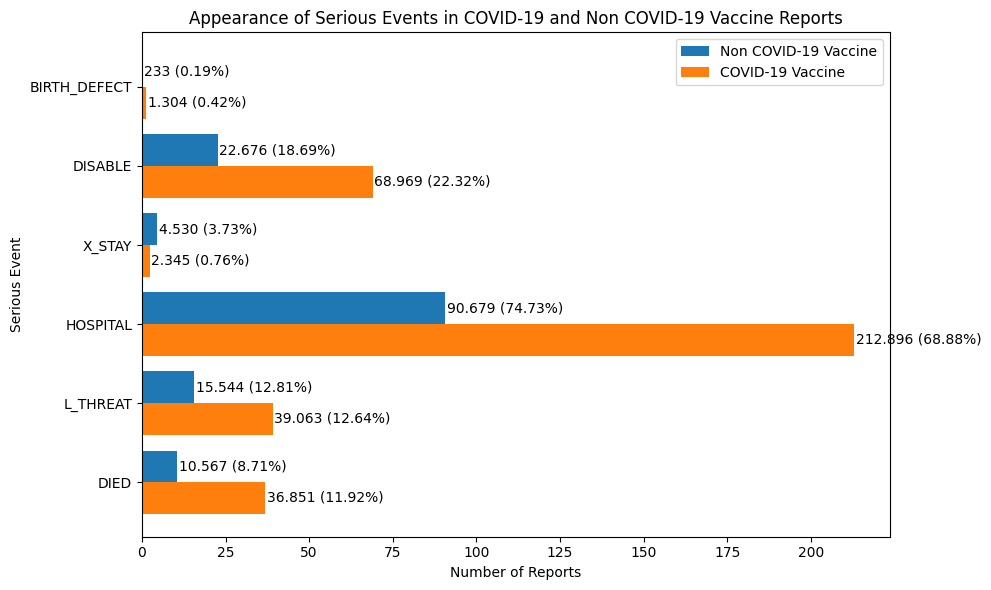

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

# Define the serious columns
serious_columns = ['DIED', 'L_THREAT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'BIRTH_DEFECT']

# Initialize dictionaries to store the counts for each serious event
serious_counts_covid = {column: 0 for column in serious_columns}
serious_counts_non_covid = {column: 0 for column in serious_columns}

# Construct the pipeline for MongoDB aggregation to fetch all serious reports with COVID vaccine type
pipeline_serious_covid = [
    {
        "$match": {
            "SERIOUS": "Y",  # Select only serious reports
            "vax_data.VAX_TYPE": {"$regex": "COVID"}  # Select reports with vaccine type containing "COVID"
        }
    }
]

# Execute the aggregation pipeline to fetch all serious reports with COVID vaccine type
results_serious_covid = list(collection.aggregate(pipeline_serious_covid))

# Calculate the total number of reports for COVID vaccines
total_reports_covid = len(results_serious_covid)

# Iterate over all serious reports with COVID vaccine type
for entry in results_serious_covid:
    for column in serious_columns:
        if entry.get(column, "") == "Y":
            serious_counts_covid[column] += 1

# Construct the pipeline for MongoDB aggregation to fetch all serious reports with non-COVID vaccine type
pipeline_serious_non_covid = [
    {
        "$match": {
            "SERIOUS": "Y",  # Select only serious reports
            "vax_data": {
                "$elemMatch": {
                    "VAX_TYPE": {"$not": {"$regex": "COVID"}}  # Select reports with at least one vaccine type not containing "COVID"
                }
            }
        }
    }
]

# Execute the aggregation pipeline to fetch all serious reports with non-COVID vaccine type
results_serious_non_covid = list(collection.aggregate(pipeline_serious_non_covid))

# Calculate the total number of reports for non-COVID vaccines
total_reports_non_covid = len(results_serious_non_covid)

# Iterate over all serious reports with non-COVID vaccine type
for entry in results_serious_non_covid:
    for column in serious_columns:
        if entry.get(column, "") == "Y":
            serious_counts_non_covid[column] += 1

# Create DataFrames for plotting
serious_df_covid = pd.DataFrame({'Count': serious_counts_covid.values()}, index=serious_counts_covid.keys())
serious_df_non_covid = pd.DataFrame({'Count': serious_counts_non_covid.values()}, index=serious_counts_non_covid.keys())

# Calculate the percentage for each DataFrame
serious_df_covid['Percentage'] = (serious_df_covid['Count'] / total_reports_covid) * 100
serious_df_non_covid['Percentage'] = (serious_df_non_covid['Count'] / total_reports_non_covid) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Number of rows
num_rows = len(serious_columns)

# Generating positions for the bars
y = np.arange(num_rows)

# Bar width
bar_width = 0.4

# Plot the bars for non-COVID-19 vaccine
plt.barh(y + bar_width/2, serious_df_non_covid['Count'], bar_width, label='Non COVID-19 Vaccine')
# Plot the bars for COVID-19 vaccine
plt.barh(y - bar_width/2, serious_df_covid['Count'], bar_width, label='COVID-19 Vaccine')

# Set y-axis labels
plt.yticks(y, serious_columns)

# Add labels and title
plt.xlabel('Number of Reports')
plt.ylabel('Serious Event')
plt.title('Appearance of Serious Events in COVID-19 and Non COVID-19 Vaccine Reports')

# Add legend
plt.legend()

# Add numbers to the bars with percentage value, formatted with a dot for thousands
def format_with_period(number):
    return format(number, ",.0f").replace(",", ".")  # Format with dot separator

for i, (count1, count2, pct1, pct2) in enumerate(zip(serious_df_covid["Count"], serious_df_non_covid["Count"],
                                                     serious_df_covid["Percentage"], serious_df_non_covid["Percentage"])):
    label1 = f'{format_with_period(count1)} ({pct1:.2f}%)'
    label2 = f'{format_with_period(count2)} ({pct2:.2f}%)'
    
    plt.text(count1 + 500, i - bar_width/2, label1, ha='left', va='center', fontsize=10)  # Adjusted position for count1
    plt.text(count2 + 500, i + bar_width/2, label2, ha='left', va='center', fontsize=10)  # Adjusted position for count2

# Define the custom formatter function
def format_with_thousands_sep(x, pos):
    return f'{x/1000:,.0f}'

# Set the formatter for the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_with_thousands_sep))

# Show the plot
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Serious_Events/Serious_Events_total_non_Covid19_Vaccines_Individual_Comparison.png')
plt.show()
